# Mollow triplets

In [1]:
from functools import partial

import pickle
import numpy as np
from scipy.fftpack import fft
from scipy.integrate import quad
import matplotlib.pyplot as plt

import pysme.integrate as integ
import pysme.hierarchy as hier

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# define Qubit operators
sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
sy = np.array([[0, -1.j], [1.j, 0]], dtype=np.complex)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
Id = np.eye(2, dtype=np.complex)
sp = (sx + 1.j * sy) / 2
sm = (sx - 1.j * sy) / 2
zero = np.zeros((2, 2), dtype=np.complex)

In [4]:
plt.style.use('paper.mplstyle')

A coherent drive adds a Hamiltonian term.
\begin{align}
    d\rho&=dt[\beta^*L-\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    &=-idt[i\beta^*L-i\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    H_{\text{eff}}&=i\beta^*L-i\beta L^\dagger
\end{align}
Rabi frequency $\Omega=2|\beta|$. Carmichæl notates the Rabi frequency as $2\Omega$, so $\Omega=|\beta|$.

In [5]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

In [6]:
def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

In [7]:
quad(lambda t: xi_rect(t, a=0, b=2)**2, -1, 3)

In [19]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

def Heff_fn(beta, L):
    return 1.j*np.conj(beta)*L - 1.j*beta*L.conj().T

def calc_hier_auto_corr(xi_fn, L, r, mu, beta, gamma, m_max, taus, rho_ss, t, t0=0, timesteps=2**10):
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, np.sqrt(gamma) * L, Heff_fn(beta, L), r, mu)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    sp_ss_t = soln_t.get_expectations(sp, vac_rho(m_max), idx_slice=np.s_[-1], hermitian=False)
    rho_ss_t = soln_t.get_hierarchy_density_matrices(np.s_[-1])
    L_t_t = rho_ss_t @ np.kron(sp, Id_field)
    L_t_taus = integrator.integrate_hier_init_cond(L_t_t, taus + t)
    Expt_t_taus = L_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    soln_t_taus = integrator.integrate_hier_init_cond(rho_ss_t, taus + t)
    sm_ss_t_taus = soln_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    # Subtract off a bunch of stuff that gets rid of the delta
    return (Expt_t_taus - sp_ss_t * sm_ss - sp_ss * sm_ss_t_taus + sp_ss * sm_ss,
            sp_ss, sm_ss, sp_ss_t, sm_ss_t_taus)

def calc_white_auto_corr(L, gamma, beta, r, mu, times_ss, taus):
    N = np.sinh(r)**2
    M_sq = np.exp(2.j * mu) * np.sinh(r) * np.cosh(r)
    integrator = integ.UncondGaussIntegrator(np.sqrt(gamma)*L, M_sq, N, Heff_fn(beta, L))
    soln_ss = integrator.integrate(Id/2, times_ss)

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus)

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)
    return rho_ss, Expt_t_taus - sp_ss * sm_ss

In [9]:
def plot_emission_spectra(auto_corrs, labels, Rabi_offset, kwargs_plots=None, width=50, ax=None, figsize=(10,3), broadband=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        return_fig = True
    else:
        return_fig = False
    if kwargs_plots is None:
        kwargs_plots = it.repeat({}, len(auto_corrs))
    for auto_corr, label, kwargs in zip(auto_corrs, labels, kwargs_plots):
        ywf = fft(auto_corr.real)
        ax.plot(np.abs(np.hstack([ywf[-width:], ywf[:width]])), label=label, **kwargs)
    ax.legend()
    ax.set_xticks([width - Rabi_offset, width, width + Rabi_offset])
    ax.set_xticklabels([r'$\omega_c-\Omega$', r'$\omega_c$', r'$\omega_c+\Omega$'])
    ax.set_yticks([])
    ax.set_ylim(0, None)
    ax.set_ylabel(r'$S(\omega)$')
    ax.set_xlabel(r'$\omega$')
    return (fig, ax) if return_fig else None

In [10]:
rho0 = (Id - sz) / 2
S = Id
L = sm
H = zero

In [11]:
gamma = 0.5
beta = 8.j
T = 2**8
taus = np.linspace(0, T, 2**13)
times_ss = np.linspace(0, 32, 2**12)
d_omega = 2*np.pi / T
Rabi_offset = 2*np.abs(beta) // d_omega

In [12]:
rho_ss_coh, delta_Expt_t_taus_coh = calc_white_auto_corr(L, gamma, beta, 0, 0, times_ss, taus)

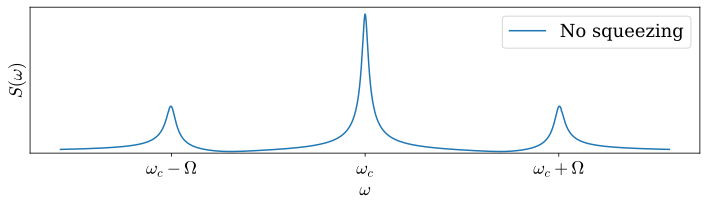

In [13]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh], ['No squeezing'], Rabi_offset, width=2**10)
plt.tight_layout()

In [14]:
r = np.log(2)
mu = 0
rho_ss_sq, delta_Expt_t_taus_sq = calc_white_auto_corr(L, gamma, beta, r, mu, times_ss, taus)

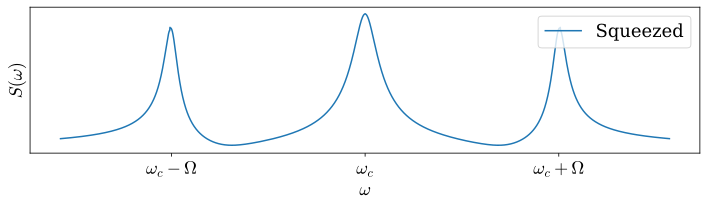

In [15]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_sq], ['Squeezed'], Rabi_offset, width=2**10)
plt.tight_layout()

In [16]:
r = np.log(2)
mu = np.pi/2
rho_ss_antisq, delta_Expt_t_taus_antisq = calc_white_auto_corr(L, gamma, beta, r, mu, times_ss, taus)

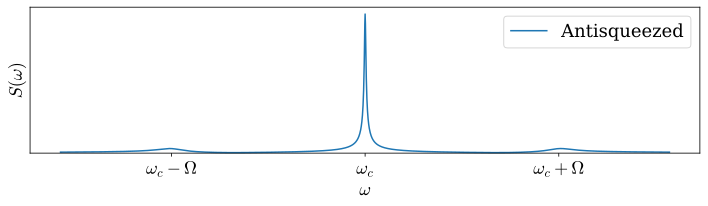

In [17]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_antisq], ['Antisqueezed'], Rabi_offset, width=2**10)
plt.tight_layout()

In [21]:
r = np.log(2)
mu = 0
m_max = 12
Expt_t_taus_wavepacket = calc_hier_auto_corr(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                             L, r, mu, beta, gamma, m_max,
                                             taus, rho_ss_coh, t=0.5)

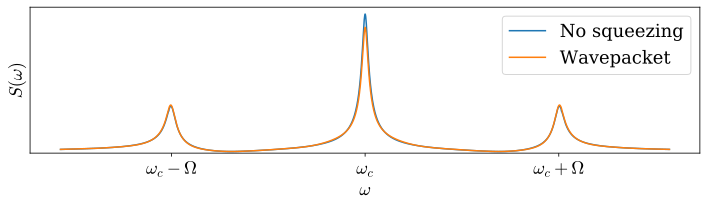

In [23]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh,
                                 Expt_t_taus_wavepacket[0]],
                                ['No squeezing',
                                 'Wavepacket'],
                                Rabi_offset, width=2**10)
plt.tight_layout()